In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import pickle
from sklearn.metrics import *
import pandas as pd
import seaborn as sns
import statsmodels

In [2]:
from all_models import *

In [3]:
fits_single = pickle.load(open('fit_single_CV_704.pickle', 'rb'))
fits_dual = pickle.load(open('fit_dual_CV_704.pickle', 'rb'))
curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))
curvatures_smooth = curvatures_smooth/(np.pi/2)


In [4]:
all_A = np.zeros(32*100)
all_B = np.zeros(32*100)
all_Af = np.zeros(32*100)
all_Bf = np.zeros(32*100)
all_As = np.zeros(32*100)
all_Bs = np.zeros(32*100)


for i in range(100):
    all_A[i*32:(i+1)*32] = fits_single[i][:, 0]
    all_B[i*32:(i+1)*32] = fits_single[i][:, 1]
    all_Af[i*32:(i+1)*32] = fits_dual[i][:, 0]
    all_Bf[i*32:(i+1)*32] = fits_dual[i][:, 1]
    all_As[i*32:(i+1)*32] = fits_dual[i][:, 2]
    all_Bs[i*32:(i+1)*32] = fits_dual[i][:, 3]


In [5]:
parameters_df = pd.DataFrame({'Participant_Id': np.tile(range(32), 100),
                              'Rotation': np.tile(['Sudden', 'Gradual'], 16*100), 
                              'A': all_A,
                              'B': all_B,
                              'Af': all_Af, 
                              'Bf': all_As, 
                              'As': all_As,
                              'Bs': all_Bs                              
                        })

In [46]:
parameter_means = parameters_df.groupby(['Participant_Id', 'Rotation']).mean().reset_index()
parameter_means['ratio'] = parameter_means['Bs']/(parameter_means['Bs'] + parameter_means['Bf'])

Text(0.5, 1.0, 'End Point Feedback')

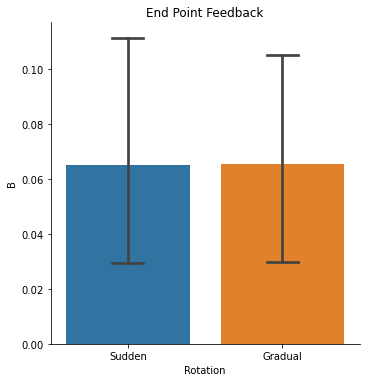

In [80]:
sns.catplot(x = 'Rotation', y = 'B', data = parameter_means, kind = 'bar', capsize = 0.2)
plt.title('End Point Feedback')

In [65]:
param = 'Af'
stat.ttest_ind(parameter_means[param][parameter_means['Rotation'] == 'Gradual'], parameter_means[param][parameter_means['Rotation'] == 'Sudden'])

Ttest_indResult(statistic=1.8316046216931368, pvalue=0.07695705516676128)

In [5]:
num_trials = 704
num_participants = 32
model_errors_fast = np.zeros((100, num_participants, num_trials))
model_errors_slow = np.zeros((100, num_participants, num_trials))
r_est = np.zeros((100, num_participants, num_trials))
e_est = np.zeros((100, num_participants, num_trials))

for i in range(100):
    for participant in range(num_participants):
        if participant%2 == 0:

            e_est[i][participant], r_est[i][participant], model_errors_fast[i][participant], model_errors_slow[i][participant]  = dual_model_sudden(704, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])
        
        else:
            e_est[i][participant], r_est[i][participant], model_errors_fast[i][participant], model_errors_slow[i][participant] = dual_model_gradual(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])
        

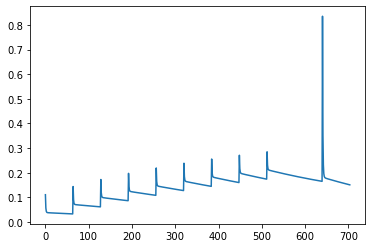

In [6]:
plt.plot(np.mean(e_est[:, 1], axis = 0))

In [7]:
estimates_df = pd.DataFrame({'Participant_Id': np.tile(np.repeat(np.arange(num_participants), 704), 100), 
                             'Trial': np.tile(np.arange(704), num_participants*100), 
                             'Block': np.tile(np.repeat(np.arange(1, 12), 64), num_participants*100), 
                             'E_est': np.ravel(e_est),
                             'R_est': np.ravel(r_est),
                             'Fast_est': np.ravel(model_errors_fast),
                             'Slow_est': np.ravel(model_errors_slow),
                             'Condition': np.tile(np.repeat(['Sudden_Accuracy', 'Gradual_Accuracy'], 704), 16*100), 
                             'slow/(fast+slow)': np.ravel(model_errors_slow)/(np.ravel(r_est) + 0.00001),
                             'fast/(fast+slow)': np.ravel(model_errors_fast)/(np.ravel(r_est) + 0.00001), 
                             'slow/fast': np.ravel(model_errors_slow)/(np.ravel(model_errors_fast) + 0.00001)

                            })
estimates_df['Slow-Fast'] = estimates_df['Slow_est'] - estimates_df['Fast_est']


In [8]:
estimate_means = estimates_df.groupby(['Participant_Id', 'Block', 'Condition']).mean().reset_index()


In [9]:
estimate_means_melted = estimate_means.melt(['Participant_Id', 'Block', 'Condition', 'Trial', 'slow/fast'], var_name='Estimates')

(0.0, 1.0)

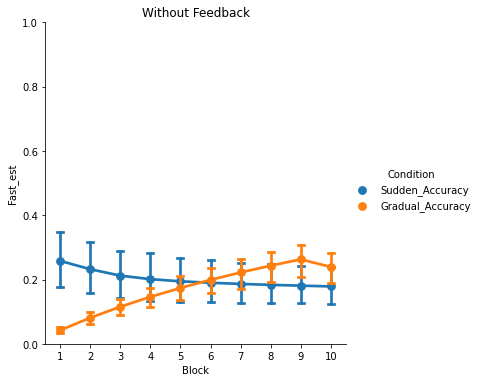

In [10]:
sns.catplot(x = 'Block', y = 'Fast_est', hue = 'Condition',  
            data = estimate_means[estimate_means['Block'] < 11], kind = 'point', capsize = 0.2)
plt.title('Without Feedback')
plt.ylim((0, 1))